In [1]:
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/home/project/imagerecognition', one_hot = True)

Extracting /home/project/imagerecognition/train-images-idx3-ubyte.gz
Extracting /home/project/imagerecognition/train-labels-idx1-ubyte.gz
Extracting /home/project/imagerecognition/t10k-images-idx3-ubyte.gz
Extracting /home/project/imagerecognition/t10k-labels-idx1-ubyte.gz


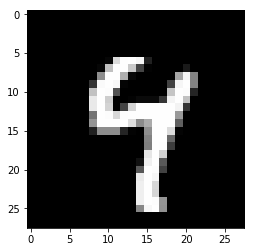

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap = 'Greys_r')

In [4]:
class NeuralNet:
    def __init__(self, initial_weights, activation_fn, use_batch_norm):
        
        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch Norm"

        self.is_training = tf.placeholder(tf.bool)

        self.training_accuracies = []

        self.build_network(initial_weights, activation_fn)
    
    def build_network(self, initial_weights, activation_fn):
        
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        for weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, weights, activation_fn)    
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
   
    def fully_connected(self, layer_in, initial_weights, activation_fn=None):
        
        if self.use_batch_norm and activation_fn:
            weights = tf.Variable(initial_weights)
            linear_output = tf.matmul(layer_in, weights)
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
            return activation_fn(batch_normalized_output)
        
        else:
            weights = tf.Variable(initial_weights)
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), biases)
            return linear_output if not activation_fn else activation_fn(linear_output)

    def train(self, session, learning_rate, training_batches, batches_per_sample, save_model_as=None):
        
        labels = tf.placeholder(tf.float32, [None, 10])
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = self.output_layer))
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        if self.use_batch_norm:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
        for i in tqdm.tqdm(range(training_batches)):
            # We use batches of 60 just because the original paper did. You can use any size batch you like.
            batch_xs, batch_ys = mnist.train.next_batch(60)
            session.run(train_step, feed_dict = {self.input_layer: batch_xs, labels: batch_ys, self.is_training: True})
        
            # Periodically test accuracy against the 5k validation images and store it for plotting later.
            if i % batches_per_sample == 0:
                test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                                 labels: mnist.validation.labels,
                                                                 self.is_training: False})
                self.training_accuracies.append(test_accuracy)

        # After training, report accuracy against test data
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                         labels: mnist.validation.labels,
                                                         self.is_training: False})
        
        print('{}: After training, final accuracy on validation set = {}'.format(self.name, test_accuracy))

        # If you want to use this model later for inference instead of having to retrain it,
        # just construct it with the same parameters and then pass this file to the 'test' function
        if save_model_as:
            tf.train.Saver().save(session, save_model_as)

    def test(self, session, test_training_accuracy = False, include_individual_predictions = False, restore_from = None):
        
        # This placeholder will store the true labels for each mini batch
        labels = tf.placeholder(tf.float32, [None, 10])

        # Define operations for testing
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # If provided, restore from a previously saved model
        if restore_from:
            tf.train.Saver().restore(session, restore_from)

        # Test against all of the MNIST test data
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                         labels: mnist.test.labels,
                                                         self.is_training: test_training_accuracy})
        print('-' * 75)
        print('{}: Accuracy on full test set = {}'.format(self.name, test_accuracy))

        # If requested, perform tests predicting individual values rather than batches
        if include_individual_predictions:
            predictions = []
            correct = 0

            # Do 200 predictions, 1 at a time
            for i in range(200):
                # This is a normal prediction using an individual test case. However, notice
                # we pass `test_training_accuracy` to `feed_dict` as the value for `self.is_training`.
                # Remember that will tell it whether it should use the batch mean & variance or
                # the population estimates that were calucated while training the model.
                pred, corr = session.run([tf.arg_max(self.output_layer,1), accuracy],
                                         feed_dict={self.input_layer: [mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]],
                                                    self.is_training: test_training_accuracy})
                correct += corr

                predictions.append(pred[0])

            print("200 Predictions: ", predictions)
            print("Accuracy on 200 samples: ", correct/200)

In [5]:
def plot_training_accuracies(*args, **kwargs):
    fig, ax = plt.subplots()

    batches_per_sample = kwargs['batches_per_sample']
    
    for nn in args:
        ax.plot(range(0,len(nn.training_accuracies) * batches_per_sample, batches_per_sample),
                nn.training_accuracies, label = nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc = 4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

def train_and_test(use_bad_weights, learning_rate, activation_fn, training_batches = 50000, batches_per_sample = 500):
    
    if use_bad_weights:
        # These weights should be horrible because they have such a large standard deviation
        weights = [np.random.normal(size = (784, 100), scale = 5.0).astype(np.float32),
                   np.random.normal(size = (100, 100), scale = 5.0).astype(np.float32),
                   np.random.normal(size = (100, 100), scale = 5.0).astype(np.float32),
                   np.random.normal(size = (100, 10), scale = 5.0).astype(np.float32)]
    else:
        # These weights should be good because they have such a small standard deviation
        weights = [np.random.normal(size = (784, 100), scale = 0.05).astype(np.float32),
                   np.random.normal(size = (100, 100), scale = 0.05).astype(np.float32),
                   np.random.normal(size = (100, 100), scale = 0.05).astype(np.float32),
                   np.random.normal(size = (100, 10), scale = 0.05).astype(np.float32)]

    # Just to make sure the TensorFlow's default graph is empty before we start another
    # test, because we don't bother using different graphs or scoping and naming 
    # elements carefully in this sample code.
    tf.reset_default_graph()

    # build two versions of same network, 1 without and 1 with batch normalization
    nn = NeuralNet(weights, activation_fn, False)
    bn = NeuralNet(weights, activation_fn, True)
    
    # train and test the two models
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        nn.train(sess, learning_rate, training_batches, batches_per_sample)
        bn.train(sess, learning_rate, training_batches, batches_per_sample)
    
        nn.test(sess)
        bn.test(sess)
    
    # Display a graph of how validation accuracies changed during training
    # so we can compare how the models trained and when they converged
    plot_training_accuracies(nn, bn, batches_per_sample = batches_per_sample)

100%|██████████| 50000/50000 [01:18<00:00, 677.88it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.976999759674


100%|██████████| 50000/50000 [02:29<00:00, 335.35it/s]


With Batch Norm: After training, final accuracy on validation set = 0.98199981451
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.975400149822
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.978200137615


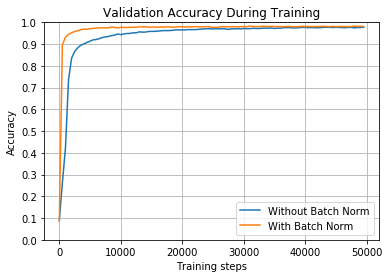

In [6]:
train_and_test(False, 0.01, tf.nn.relu)

100%|██████████| 2000/2000 [00:03<00:00, 636.69it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.834799826145


100%|██████████| 2000/2000 [00:05<00:00, 342.75it/s]


With Batch Norm: After training, final accuracy on validation set = 0.956999719143
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.832000076771
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.952600181103


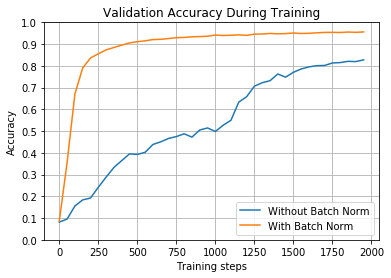

In [7]:
train_and_test(False, 0.01, tf.nn.relu, 2000, 50)

100%|██████████| 50000/50000 [01:17<00:00, 648.29it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.79039978981


100%|██████████| 50000/50000 [02:34<00:00, 324.45it/s]


With Batch Norm: After training, final accuracy on validation set = 0.971999764442
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.778299987316
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.970600128174


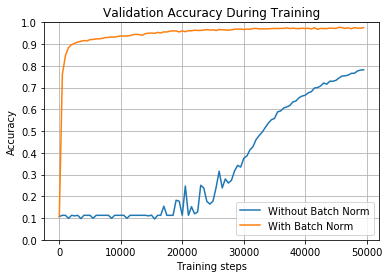

In [8]:
train_and_test(False, 0.01, tf.nn.sigmoid)

100%|██████████| 50000/50000 [01:18<00:00, 639.97it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489


100%|██████████| 50000/50000 [02:35<00:00, 320.63it/s]


With Batch Norm: After training, final accuracy on validation set = 0.985399723053
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.0979999899864
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.983500123024


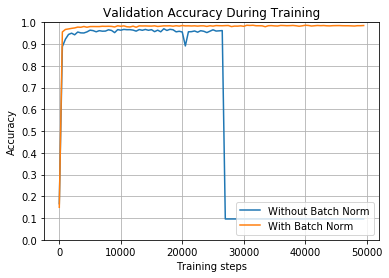

In [9]:
train_and_test(False, 1, tf.nn.relu)

100%|██████████| 50000/50000 [01:11<00:00, 701.83it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.979399681091


100%|██████████| 50000/50000 [02:31<00:00, 330.12it/s]


With Batch Norm: After training, final accuracy on validation set = 0.980599701405
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.97610014677
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.979800105095


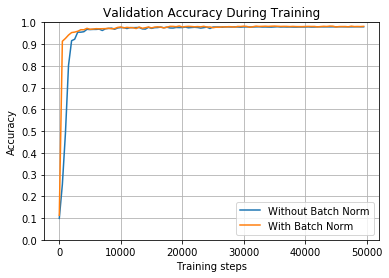

In [10]:
train_and_test(False, 1, tf.nn.sigmoid)

100%|██████████| 2000/2000 [00:02<00:00, 757.35it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.91599971056


100%|██████████| 2000/2000 [00:06<00:00, 322.56it/s]


With Batch Norm: After training, final accuracy on validation set = 0.954199790955
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.913500130177
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.951700150967


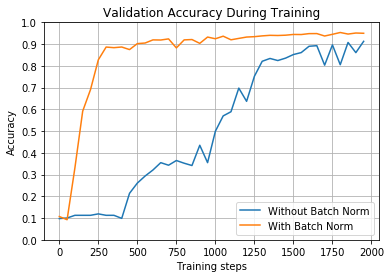

In [11]:
train_and_test(False, 1, tf.nn.sigmoid, 2000, 50)

100%|██████████| 50000/50000 [01:01<00:00, 812.70it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0985999926925


100%|██████████| 50000/50000 [02:21<00:00, 352.87it/s]


With Batch Norm: After training, final accuracy on validation set = 0.985199689865
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.100999996066
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.981900155544


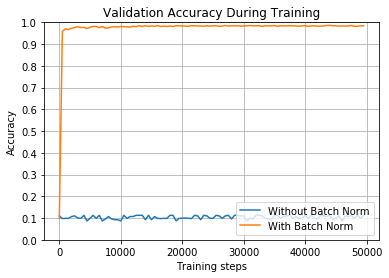

In [12]:
train_and_test(False, 2, tf.nn.relu)

100%|██████████| 50000/50000 [01:05<00:00, 768.65it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.974999666214


100%|██████████| 50000/50000 [02:38<00:00, 329.83it/s]


With Batch Norm: After training, final accuracy on validation set = 0.980799734592
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.970300078392
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.980800151825


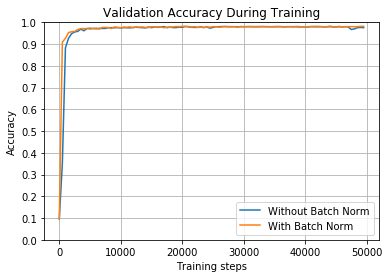

In [13]:
train_and_test(False, 2, tf.nn.sigmoid)

100%|██████████| 2000/2000 [00:02<00:00, 684.96it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.953999757767


100%|██████████| 2000/2000 [00:06<00:00, 298.81it/s]


With Batch Norm: After training, final accuracy on validation set = 0.962599694729
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.944000124931
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.958400130272


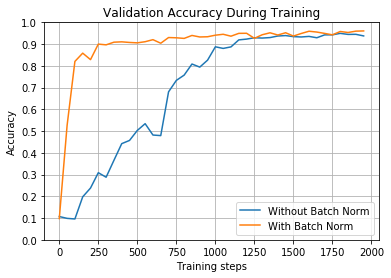

In [14]:
train_and_test(False, 2, tf.nn.sigmoid, 2000, 50)

100%|██████████| 50000/50000 [01:07<00:00, 742.08it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489


100%|██████████| 50000/50000 [02:21<00:00, 353.19it/s]


With Batch Norm: After training, final accuracy on validation set = 0.809799790382
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.0979999899864
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.809500038624


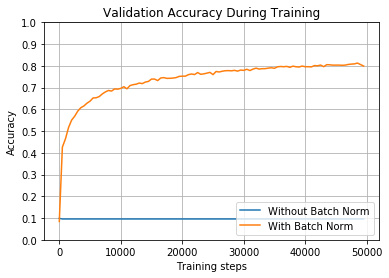

In [15]:
train_and_test(True, 0.01, tf.nn.relu)

100%|██████████| 50000/50000 [01:06<00:00, 747.46it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.310000002384


100%|██████████| 50000/50000 [02:24<00:00, 346.55it/s]


With Batch Norm: After training, final accuracy on validation set = 0.842599749565
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.296599954367
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.843200027943


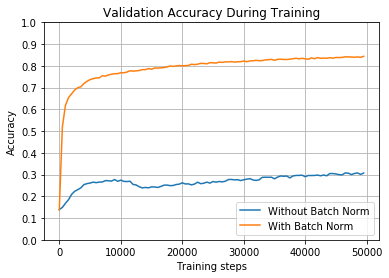

In [16]:
train_and_test(True, 0.01, tf.nn.sigmoid)

100%|██████████| 50000/50000 [00:59<00:00, 839.19it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489


100%|██████████| 50000/50000 [02:14<00:00, 370.87it/s]


With Batch Norm: After training, final accuracy on validation set = 0.803599834442
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.0979999899864
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.802900016308


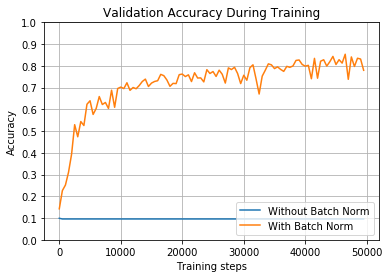

In [17]:
train_and_test(True, 1, tf.nn.relu)

100%|██████████| 50000/50000 [00:59<00:00, 834.78it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.903399705887


100%|██████████| 50000/50000 [02:16<00:00, 366.65it/s]


With Batch Norm: After training, final accuracy on validation set = 0.959399759769
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.89300006628
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.950000047684


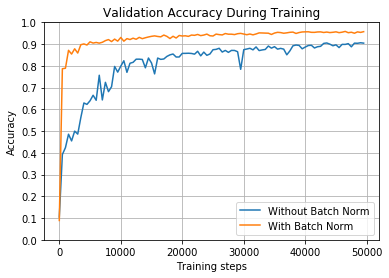

In [18]:
train_and_test(True, 1, tf.nn.sigmoid)

100%|██████████| 50000/50000 [01:03<00:00, 792.54it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489


100%|██████████| 50000/50000 [02:16<00:00, 365.66it/s]


With Batch Norm: After training, final accuracy on validation set = 0.938599765301
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.0980000048876
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.936200141907


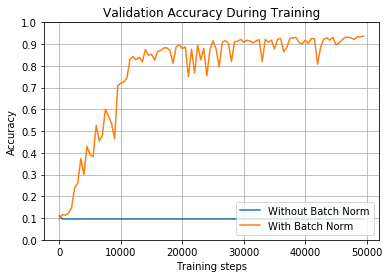

In [19]:
train_and_test(True, 2, tf.nn.relu)

100%|██████████| 50000/50000 [01:00<00:00, 822.60it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.904799699783


100%|██████████| 50000/50000 [02:16<00:00, 366.15it/s]


With Batch Norm: After training, final accuracy on validation set = 0.961799740791
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.897000074387
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.95450013876


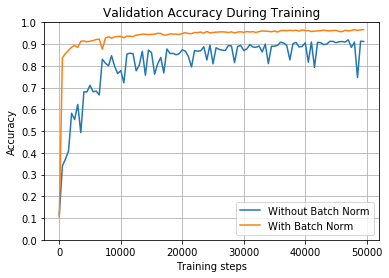

In [20]:
train_and_test(True, 2, tf.nn.sigmoid)

100%|██████████| 50000/50000 [01:03<00:00, 792.16it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489


100%|██████████| 50000/50000 [02:30<00:00, 331.82it/s]


With Batch Norm: After training, final accuracy on validation set = 0.916199684143
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.0980000048876
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.911000072956


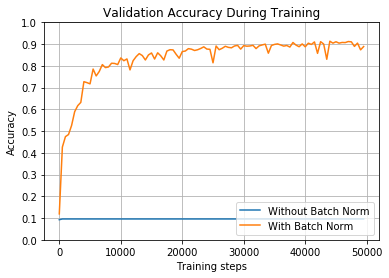

In [21]:
train_and_test(True, 1, tf.nn.relu)

100%|██████████| 50000/50000 [01:05<00:00, 758.23it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489


100%|██████████| 50000/50000 [02:22<00:00, 350.00it/s]


With Batch Norm: After training, final accuracy on validation set = 0.0957999974489
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.0980000048876
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.0980000048876


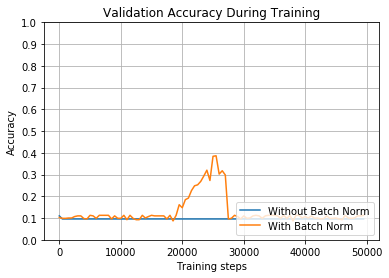

In [22]:
train_and_test(True, 2, tf.nn.relu)